# Курс от Тинькофф: Анализ данных в индустрии

### Неделя 2: Визуализация данных

### Задание 1:
Рассматриваем следующий процесс: заявители регистрируются на сайте Тинькофф Квест, где указывают свой возраст. Всех зарегистрированных называем клиентами.


В дальнейшем кто-то из них совершает с созданного аккаунта покупки сертификатов на квест. Будем называть это утилизацией. Число дней от регистрации на сайте до первой покупки будем называть скоростью утилизации.
*purchase_table.xls*

В приложенном файле таблица со следующими полями:

 - client_id -- id клиента, зарегистрированного на сайте
 - birth_dt -- дата его рождения
 - reg_dttm -- дата и время регистрации на сайте данного клиента
 - purchase_id -- id покупки
 - purchase_dt -- дата покупки
 - purchase_amt -- сумма покупки

Если данные по покупке пустые -- клиент не совершил утилизации.

*Постройте диаграмму (или график), которая показывает, как менялось множество клиентов по возрасту с течением времени.
В ответ пришлите изображение диаграммы (или графика) и код (SQL/Python), с помощью которого вы его получили*

In [1]:
# Импортируем нужные библиотеки
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Загрузим данные и посмотрим на них (данные загружаю с локального компьютера из той же папки, где лежит ноутбук)
data = pd.read_excel('purchase_table.xls')
data.head()

,client_id,birth_dt,reg_dttm,purchase_id,purchase_dt,purchase_amt
0,820519,1990-05-10,2019-01-02 12:49:39,NaN,NaT,NaN
1,820521,1970-03-23,2019-01-02 14:14:39,NaN,NaT,NaN
2,820523,1991-04-01,2019-01-02 19:51:19,1.204926e+09,2019-02-12,500.0
3,820526,1985-04-27,2019-01-02 18:09:39,NaN,NaT,NaN
4,820544,1991-05-03,2019-01-03 12:24:42,NaN,NaT,NaN


In [4]:
# Посмотрим информацию о колонках
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2377 entries, 0 to 2376
Data columns (total 6 columns):
client_id       2377 non-null int64
birth_dt        2377 non-null datetime64[ns]
reg_dttm        2377 non-null datetime64[ns]
purchase_id     1239 non-null float64
purchase_dt     1239 non-null datetime64[ns]
purchase_amt    1239 non-null float64
dtypes: datetime64[ns](3), float64(2), int64(1)
memory usage: 111.5 KB


Первые 3 колонки не содержат пропусков, а колонки __purchase__ заполнены примерно наполовину.\
Типы данных ожидаемые, кроме колонки purchase_id. Ожидаемо было бы увидеть тип int или object.\
В данном задании эта колонка не понадобится, поэтому не будем преобразовывать данные.

Создадим столбец с количеством полных лет клиента на момент регистрации.\
Поскольку в целях задачи не принципиально, 25 или 26 полных лет клиенту, то сделаем самым простым способом - просто вычтем из года рождения год регистрации.

In [5]:
data['age'] = data.reg_dttm.apply(lambda x: x.year) - data.birth_dt.apply(lambda x: x.year)

Построим гистограмму распределения клиентов по возрастам

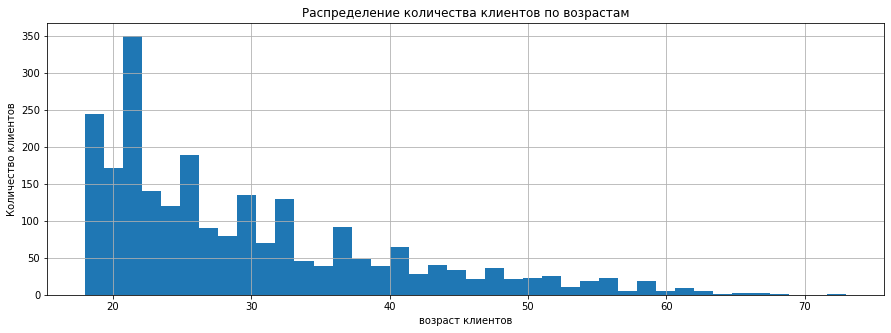

In [6]:
plt.figure(figsize=(15,5))
plt.hist(data['age'], bins=40, align='mid')
plt.title('Распределение количества клиентов по возрастам')
plt.xlabel('возраст клиентов')
plt.ylabel('Количество клиентов')
plt.grid(True)
plt.show()

Посмотрим, численное распределение значений

In [7]:
data['age'].describe()

count    2377.000000
mean       29.515776
std        10.278276
min        18.000000
25%        21.000000
50%        26.000000
75%        35.000000
max        73.000000
Name: age, dtype: float64

Какие выводы можно сделать:
- Половина клиентов младше 26 лет. 75% клиентов моложе 35 лет.
- Самому молодому клиенту 18 лет, самому старшему - 73 года.
- Половина клиентов находится в возрастной группе между 21 и 35 годами.

Чтобы посмотреть прирост количества клиентов по возрастам имеет смысл разделить клиентов на категории следующим образом:
- 18-21 лет. Сюда попадут 25% клиентов.
- 22-26 лет. Сюда попадут 25% клиентов.
- 27-35 лет. Сюда попадут 25% клиентов.
- 36-50 лет.
- 51 год и старше.

Я решила разделить последнюю категорию на 2.

In [8]:
def age_cat(age):
    if age < 22:
        return 'under 21'
    elif age < 27:
        return '22-26'
    elif age < 36:
        return '27-35'
    elif age < 51:
        return '36-50'
    else:
        return 'after 51'

data['age_categories'] = data.age.apply(age_cat)

Создадим новую таблицу только с нужными колонками

In [9]:
df = data[['reg_dttm', 'age_categories']]
df.sort_values(by = 'reg_dttm', inplace = True)

In [10]:
#Преобразуем колонку с датой (уберем время)
df['date'] = pd.to_datetime(df['reg_dttm']).dt.date

In [11]:
# Посчитаем, сколько клиентов каждой категории регистрировалось в определенный день
df_count = df.groupby(['date','age_categories'], as_index=False).count()

In [12]:
# Посчитаем кумулятивное количество клиентов
df_count['cumulative'] = df_count.groupby(['age_categories']).cumsum()['reg_dttm']

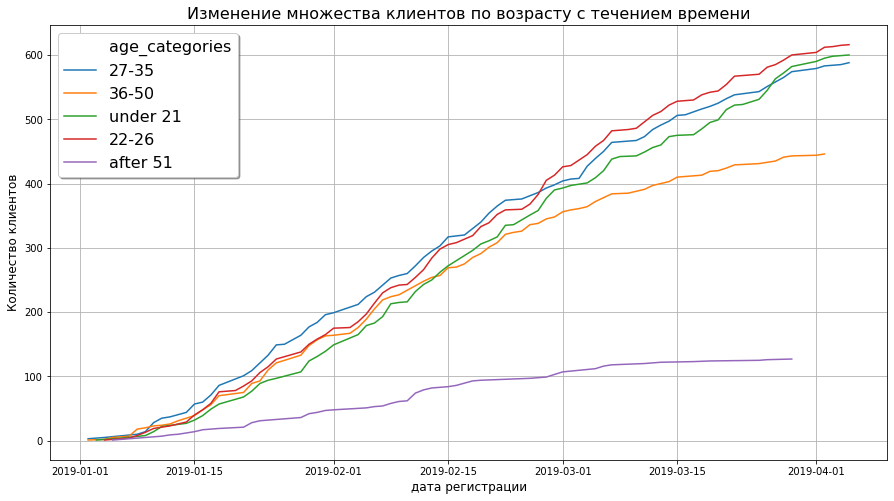

In [13]:
# Построим график кумулятивного прироста клиентов по возрастным категориям
plt.figure(figsize=(15,8))
sns.lineplot(data=df_count, x="date", y="cumulative", hue="age_categories")
plt.title('Изменение множества клиентов по возрасту с течением времени', fontsize=16)
plt.xlabel('дата регистрации', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.legend(fontsize=16, shadow=True)
plt.grid(True)
plt.savefig('clients_growth.jpg', dpi=500, optimize=True, papertype='a4')
plt.show()

### Задание 2:

*Постройте диаграмму (или график), которая показывает, как по возрастным сегментам отличается конверсия в утилизацию.
В ответ пришлите изображение диаграммы (или графика) и код (SQL/Python), с помощью которого вы его получили*

Сначала я хотела делать в отдельном ноутбуке, но задания связанные, поэтому продолжаем тут.

In [14]:
data.head()

,client_id,birth_dt,reg_dttm,purchase_id,purchase_dt,purchase_amt,age,age_categories
0,820519,1990-05-10,2019-01-02 12:49:39,NaN,NaT,NaN,29,27-35
1,820521,1970-03-23,2019-01-02 14:14:39,NaN,NaT,NaN,49,36-50
2,820523,1991-04-01,2019-01-02 19:51:19,1.204926e+09,2019-02-12,500.0,28,27-35
3,820526,1985-04-27,2019-01-02 18:09:39,NaN,NaT,NaN,34,27-35
4,820544,1991-05-03,2019-01-03 12:24:42,NaN,NaT,NaN,28,27-35


Посмотрим на среднюю конверсию по всей выборке.\
Для этого сначала избавимся от всех пропущенных значений.\
Заменим их на ноль.

In [15]:
data.fillna(0, inplace=True)
data.purchase_id = data.purchase_id.astype('int64')

In [16]:
# Переименуем категории для более красивого отображения на графиках
data.age_categories.replace('under 21', '18-21', inplace=True)
data.age_categories.replace('after 51', '51+', inplace=True)

In [17]:
# Сделаем флаг совешения утилизации и флаг совершения регистрации
data['flag_purchase'] = data.purchase_id != 0

Отберем в отдельную таблицу только столбцы с возратной категорией и флагом утилизации.\
Сгруппируем по возрастным категориям и посчитаем сумму по значением флага утилизации с нормализацией на размер категории.\
Потом умножим полученные значения на 100 (переведем их в проценты).\
И удалим из таблицы значения с флагом утилизации = False (т.е. значения, которые посчитаны для клиентов, не совершивших покупку).

In [18]:
df = data[['age_categories', 'flag_purchase']]
df_c = df.groupby(['age_categories'])['flag_purchase'].value_counts(normalize=True)
df_c = df_c.mul(100).rename('conversion').reset_index()

In [19]:
df_c = df_c[df_c.flag_purchase == True]
df_c

,age_categories,flag_purchase,conversion
0,18-21,True,58.166667
3,22-26,True,49.025974
5,27-35,True,49.829932
6,36-50,True,50.896861
8,51+,True,53.543307


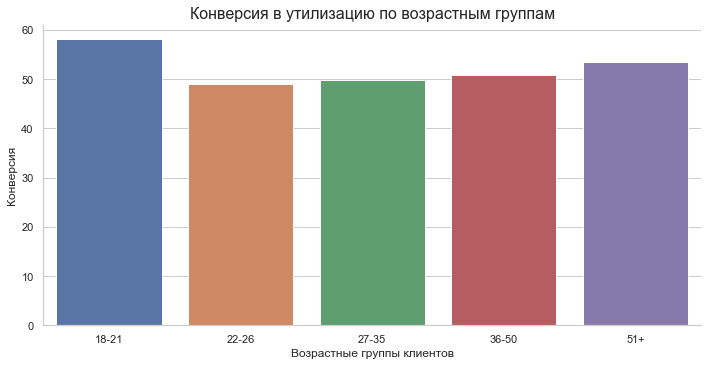

In [20]:
sns.set(style="whitegrid")
sns.catplot(x='age_categories', y='conversion', hue='age_categories',
            kind='bar',
            data=df_c,
            dodge=False,
            aspect=2,
            )
plt.title('Конверсия в утилизацию по возрастным группам', fontsize=16)
plt.xlabel('Возрастные группы клиентов', fontsize=12)
plt.ylabel('Конверсия', fontsize=12)
plt.savefig('conversion.jpg', dpi=500, optimize=True, papertype='a4', bbox_inches='tight')
plt.show()

### Задание 3 (обновленное):

*Постройте диаграмму (или график), которая показывает, как скорость утилизации влияет на размер первой покупки.
В ответ пришлите изображение диаграммы (или графика) и код (SQL/Python), с помощью которого вы его получили*

Снова загрузим исходную таблицу без изменений

In [21]:
# данные загружаю с локального компьютера из той же папки, где лежит ноутбук
data = pd.read_excel('purchase_table.xls')
data.head()

,client_id,birth_dt,reg_dttm,purchase_id,purchase_dt,purchase_amt
0,820519,1990-05-10,2019-01-02 12:49:39,NaN,NaT,NaN
1,820521,1970-03-23,2019-01-02 14:14:39,NaN,NaT,NaN
2,820523,1991-04-01,2019-01-02 19:51:19,1.204926e+09,2019-02-12,500.0
3,820526,1985-04-27,2019-01-02 18:09:39,NaN,NaT,NaN
4,820544,1991-05-03,2019-01-03 12:24:42,NaN,NaT,NaN


Поскольку в условии задания требуется исследовать влияние скорости утилизации на размер покупки, нам понадобятся только те строки, где совершена утилизация

In [25]:
data.dropna(inplace = True)

Посмотрим на уникальные значения client_id и на полное количество значений столбца client_id

In [26]:
print('Всего значений в столбце client_id:', data.client_id.shape[0])
print('Уникальных значений в столбце client_id:', data.client_id.unique().shape[0])

Всего значений в столбце client_id: 1239
Уникальных значений в столбце client_id: 961


Отсортируем по дате покупке и удалим дубликаты

In [27]:
data = data.sort_values(by = 'purchase_dt')

In [29]:
data = data.drop_duplicates(subset=['client_id']).reset_index(drop = True)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
client_id       961 non-null int64
birth_dt        961 non-null datetime64[ns]
reg_dttm        961 non-null datetime64[ns]
purchase_id     961 non-null float64
purchase_dt     961 non-null datetime64[ns]
purchase_amt    961 non-null float64
dtypes: datetime64[ns](3), float64(2), int64(1)
memory usage: 45.2 KB


In [32]:
# Уберем время из даты регистрации (оставим только дату)
data['reg_date'] = pd.to_datetime(data['reg_dttm'].dt.date)

In [33]:
# Посчитаем скорость утилизации в днях
data['purchase_speed'] = data['purchase_dt'] - data['reg_date']
data['purchase_speed'] = data['purchase_speed'].dt.days.astype('int')

In [34]:
# Отсортируем таблицу по скорости утилизации
data = data.sort_values(by = 'purchase_speed')

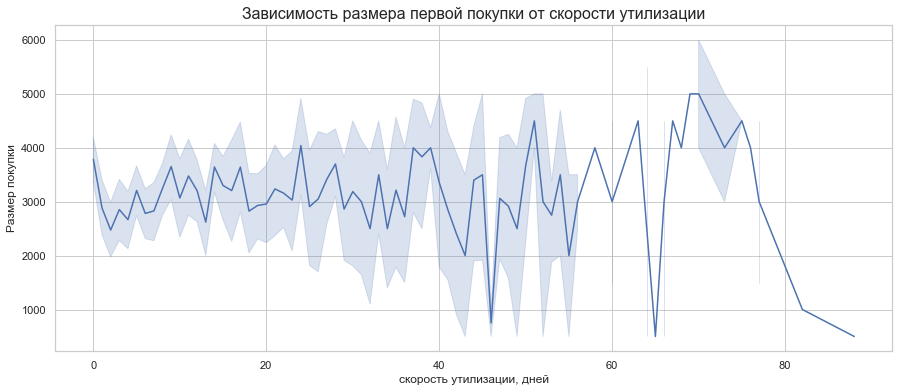

In [35]:
# Построим график соответствия скорости утилизации к стоимости первой покупки
sns.set(style="whitegrid")
plt.figure(figsize=(15,6))
sns.lineplot(data=data, x="purchase_speed", y="purchase_amt")
plt.title('Зависимость размера первой покупки от скорости утилизации', fontsize=16)
plt.xlabel('скорость утилизации, дней', fontsize=12)
plt.ylabel('Размер покупки', fontsize=12)
plt.savefig('purchase_speed_amt_uniq_id.jpg', dpi=500, optimize=True, papertype='a4', bbox_inches='tight')
plt.show()

Попробуем посмотреть на зависимость размера от скорости утилизации по неделям

In [36]:
# Уберем лишние колонки
data = data[['purchase_amt', 'purchase_speed']]

In [37]:
# Разделим скорость утилизации по неделям и посчитаем средний и медианный размер покупки в этом интервале.
lst=[]
for i in range(6, max(data['purchase_speed'].unique()), 7):
    lst.append(i)
    
def week(days):
    if days > max(lst):
        return max(lst)
    for i in lst:
        if days < i:
            return i
        
data['purchase_speed_week'] = data['purchase_speed'].apply(week)
data['purchase_speed_week'] = (data['purchase_speed_week'] + 1) // 7

In [38]:
funcs = {'median_purchase': 'median',
         'mean_purchase' : 'mean'
        }
data_agg = data.groupby(['purchase_speed_week'])['purchase_amt'].agg(funcs).reset_index()

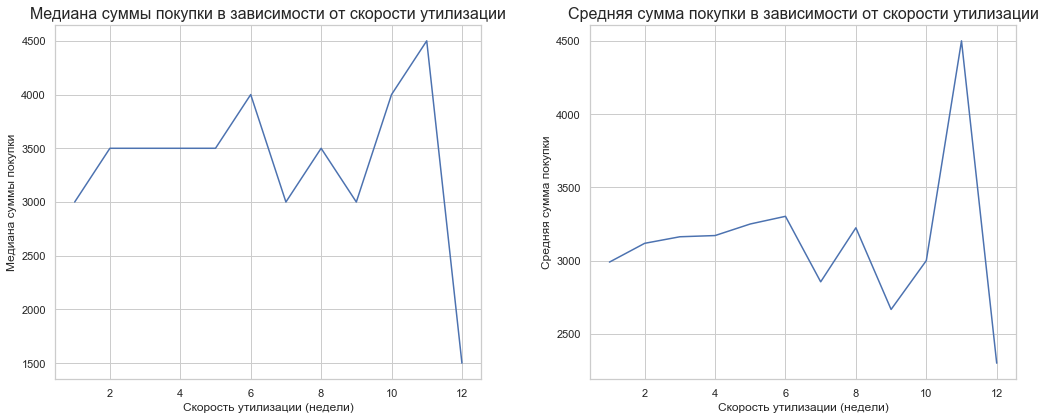

In [39]:
# Построим графики зависимости средней и медианной стоимости покупки в зависимости от скорости утилизации
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=data_agg, x="purchase_speed_week", y="median_purchase")
plt.title('Медиана суммы покупки в зависимости от скорости утилизации', fontsize=16)
plt.xlabel('Cкорость утилизации (недели)', fontsize=12)
plt.ylabel('Медиана суммы покупки', fontsize=12)
plt.subplot(1, 2, 2)
sns.lineplot(data=data_agg, x="purchase_speed_week", y="mean_purchase")
plt.title('Средняя сумма покупки в зависимости от скорости утилизации', fontsize=16)
plt.xlabel('Cкорость утилизации (недели)', fontsize=12)
plt.ylabel('Средняя сумма покупки', fontsize=12)
fig.tight_layout()
plt.savefig('purchase_speed_amt_median_mean_uniq_id.jpg', dpi=500, optimize=True, papertype='a4', bbox_inches='tight')
fig.show()

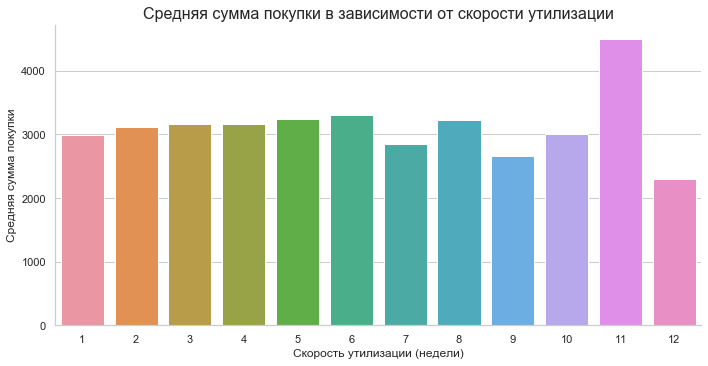

In [41]:
# Построим гистограмму средних значений размера покупки в зависимости от скорости утилизации
sns.catplot(x='purchase_speed_week', y='purchase_amt',
            kind='bar',
            data=data,
            dodge=False,
            aspect=2,
            ci=None
            )

plt.title('Средняя сумма покупки в зависимости от скорости утилизации', fontsize=16)
plt.xlabel('Cкорость утилизации (недели)', fontsize=12)
plt.ylabel('Средняя сумма покупки', fontsize=12)
fig.tight_layout()
plt.savefig('purchase_speed_amt_mean_bar_uniq_id.jpg', dpi=500, optimize=True, papertype='a4', bbox_inches='tight')
fig.show()

### Задание 3 (первая версия, учитывающая все покупки):

*Постройте диаграмму (или график), которая показывает, как скорость утилизации влияет на размер первой покупки.
В ответ пришлите изображение диаграммы (или графика) и код (SQL/Python), с помощью которого вы его получили*

Снова загрузим исходную таблицу без изменений

In [495]:
# данные загружаю с локального компьютера из той же папки, где лежит ноутбук
data = pd.read_excel('purchase_table.xls')
data.head()

,client_id,birth_dt,reg_dttm,purchase_id,purchase_dt,purchase_amt
0,820519,1990-05-10,2019-01-02 12:49:39,NaN,NaT,NaN
1,820521,1970-03-23,2019-01-02 14:14:39,NaN,NaT,NaN
2,820523,1991-04-01,2019-01-02 19:51:19,1.204926e+09,2019-02-12,500.0
3,820526,1985-04-27,2019-01-02 18:09:39,NaN,NaT,NaN
4,820544,1991-05-03,2019-01-03 12:24:42,NaN,NaT,NaN


Поскольку в условии задания требуется исследовать влияние скорости утилизации на размер покупки, нам понадобятся только те строки, где совершена утилизация

In [496]:
data.dropna(inplace = True)

In [497]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1239 entries, 2 to 2374
Data columns (total 6 columns):
client_id       1239 non-null int64
birth_dt        1239 non-null datetime64[ns]
reg_dttm        1239 non-null datetime64[ns]
purchase_id     1239 non-null float64
purchase_dt     1239 non-null datetime64[ns]
purchase_amt    1239 non-null float64
dtypes: datetime64[ns](3), float64(2), int64(1)
memory usage: 67.8 KB


In [498]:
# Уберем время из даты регистрации (оставим только дату)
data['reg_date'] = pd.to_datetime(data['reg_dttm'].dt.date)

In [499]:
# Посчитаем скорость утилизации в днях
data['purchase_speed'] = data['purchase_dt'] - data['reg_date']

In [500]:
data['purchase_speed'] = data['purchase_speed'].dt.days.astype('int')

In [501]:
# Отсортируем таблицу по скорости утилизации
data = data.sort_values(by = 'purchase_speed')

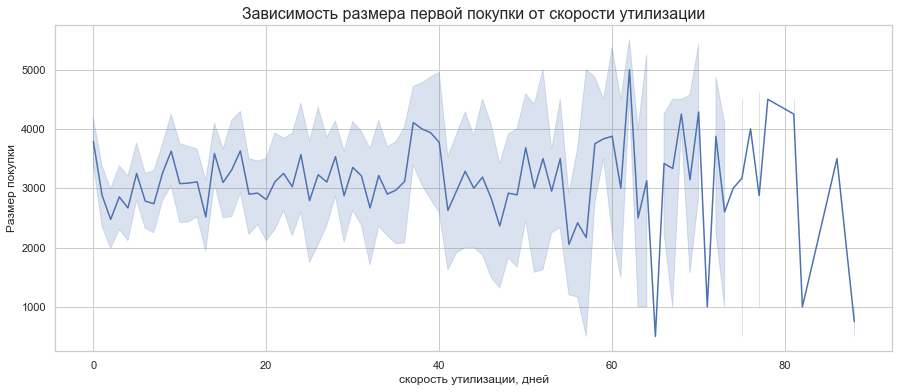

In [502]:
# Построим график соответствия скорости утилизации к стоимости первой покупки
sns.set(style="whitegrid")
plt.figure(figsize=(15,6))
sns.lineplot(data=data, x="purchase_speed", y="purchase_amt")
plt.title('Зависимость размера первой покупки от скорости утилизации', fontsize=16)
plt.xlabel('скорость утилизации, дней', fontsize=12)
plt.ylabel('Размер покупки', fontsize=12)
plt.savefig('purchase_speed_amt.jpg', dpi=500, optimize=True, papertype='a4', bbox_inches='tight')
plt.show()

На мой взгляд график мало о чем говорит. Нужно исследовать данные по-другому.

In [503]:
# Посмотрим, какие значения принимает скорость утилизации
data['purchase_speed'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 81, 82, 86, 88],
      dtype=int64)

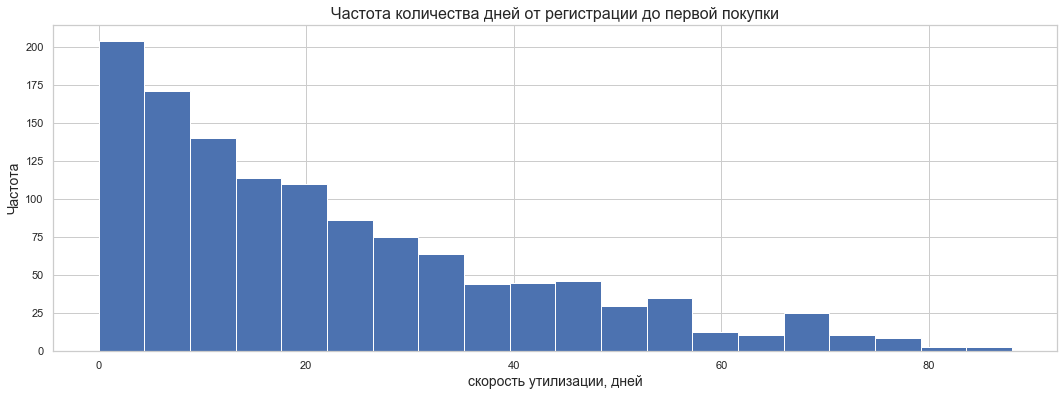

In [504]:
data['purchase_speed'].hist(figsize = (18, 6), bins=20, align='mid')
plt.title('Частота количества дней от регистрации до первой покупки', fontsize=16)
plt.xlabel('скорость утилизации, дней', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.show()

График достаточно показательный. Т.е. чем больше дней прошло с момента регистрации, тем меньше вероятность совершения покупки

In [505]:
# Посмотрим, какие значения размер покупки
data['purchase_amt'].unique()

array([5500., 5000., 3000., 2500.,  500., 4000., 3500., 4500., 2000.,
       1000., 1500., 6000., 6500., 7000.])

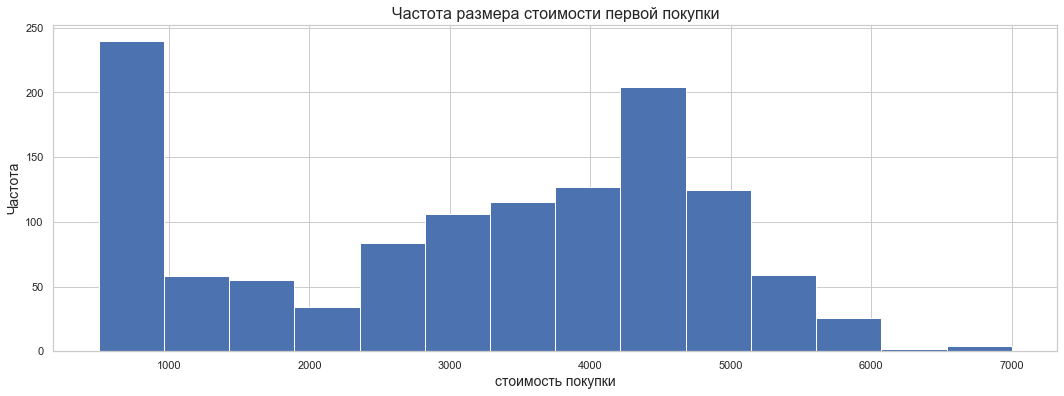

In [506]:
data['purchase_amt'].hist(figsize = (18, 6), bins=14, align='mid')
plt.title('Частота размера стоимости первой покупки', fontsize=16)
plt.xlabel('стоимость покупки', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.show()

Оставим в таблице только нужные столбцы

In [507]:
data = data[['purchase_amt', 'purchase_speed']]

In [508]:
data.describe()

,purchase_amt,purchase_speed
count,1239.000000,1239.000000
mean,3092.413236,22.135593
std,1730.223749,18.896479
min,500.000000,0.000000
25%,1500.000000,7.000000
50%,3500.000000,17.000000
75%,4500.000000,33.000000
max,7000.000000,88.000000


In [509]:
# Разделим скорость утилизации по неделям и посчитаем средний и медианный размер покупки в этом интервале.
lst=[]
for i in range(6, max(data['purchase_speed'].unique()), 7):
    lst.append(i)
    
def week(days):
    if days > max(lst):
        return max(lst)
    for i in lst:
        if days < i:
            return i
        
data['purchase_speed_week'] = data['purchase_speed'].apply(week)
data['purchase_speed_week'] = (data['purchase_speed_week'] + 1) // 7

In [510]:
funcs = {'median_purchase': 'median',
         'mean_purchase' : 'mean'
        }
data_agg = data.groupby(['purchase_speed_week'])['purchase_amt'].agg(funcs).reset_index()

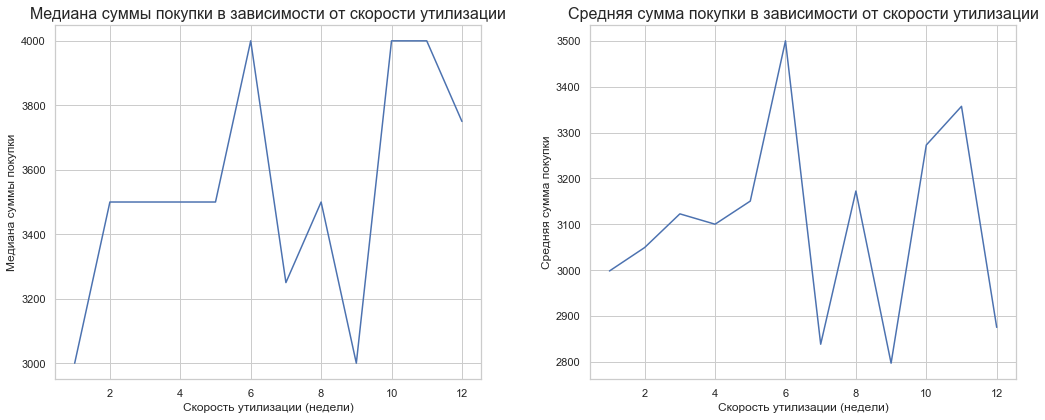

In [511]:
# Построим графики зависимости средней и медианной стоимости покупки в зависимости от скорости утилизации
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=data_agg, x="purchase_speed_week", y="median_purchase")
plt.title('Медиана суммы покупки в зависимости от скорости утилизации', fontsize=16)
plt.xlabel('Cкорость утилизации (недели)', fontsize=12)
plt.ylabel('Медиана суммы покупки', fontsize=12)
plt.subplot(1, 2, 2)
sns.lineplot(data=data_agg, x="purchase_speed_week", y="mean_purchase")
plt.title('Средняя сумма покупки в зависимости от скорости утилизации', fontsize=16)
plt.xlabel('Cкорость утилизации (недели)', fontsize=12)
plt.ylabel('Средняя сумма покупки', fontsize=12)
fig.tight_layout()
plt.savefig('purchase_speed_amt_median_mean.jpg', dpi=500, optimize=True, papertype='a4', bbox_inches='tight')
fig.show()

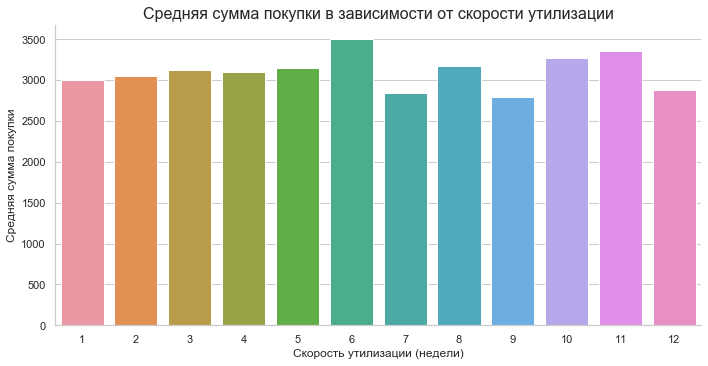

In [515]:
# Построим гистограмму средних значений размера покупки в зависимости от скорости утилизации
sns.catplot(x='purchase_speed_week', y='purchase_amt',
            kind='bar',
            data=data,
            dodge=False,
            aspect=2,
            ci=None
            )

plt.title('Средняя сумма покупки в зависимости от скорости утилизации', fontsize=16)
plt.xlabel('Cкорость утилизации (недели)', fontsize=12)
plt.ylabel('Средняя сумма покупки', fontsize=12)
fig.tight_layout()
plt.savefig('purchase_speed_amt_mean_bar.jpg', dpi=500, optimize=True, papertype='a4', bbox_inches='tight')
fig.show()